In [46]:
import pandas as pd

df = pd.read_csv("data/player_stats-2.csv")
#df = df[df["yearID"] == 2014]
df = df[df["leagueID"] == "NL"]
df = df[["playerID", "br_WAR_total", "salary", "pitcher"]]
# get rows where no column has NaN
df = df.dropna()
# keep unique playerID and keep the first if duplicates are found
df = df.drop_duplicates(subset="playerID", keep="first")
#min max scale salary
df["salary_min_max"] = (df["salary"] - df["salary"].min()) / (df["salary"].max() - df["salary"].min())
#min max scale br_WAR_total
df["br_WAR_total_min_max"] = (df["br_WAR_total"] - df["br_WAR_total"].min()) / (df["br_WAR_total"].max() - df["br_WAR_total"].min())

# Setting all variables

In [33]:
BUDGET = 50_000_000
SAMPLE_SIZE = 10000
PLAYER_COUNT = 26
BOOTSTRAP_SIZE = 100
COOLING_RATE = 0.03

# Find optimal solution

In [34]:
import pulp

df1 = df

# Create a linear programming model
model = pulp.LpProblem("Best Baseball Team", pulp.LpMaximize)

# Define the variables for the problem
# Each variable represents a player and has a value of 1 if the player is selected for the team and 0 otherwise
player_vars = pulp.LpVariable.dicts("Player", df1["playerID"].unique().tolist(), 0, 1, pulp.LpInteger)

# Define the objective function
# The objective function is to maximize the total WAR of the team
model += sum(player_vars[row["playerID"]] * row["br_WAR_total"] for index, row in df1.iterrows())

# Define the budget constraint
# The total salary of the team must be less than or equal to the budget
model += sum(player_vars[row["playerID"]] * row["salary"] for index, row in df1.iterrows()) <= BUDGET

# Define the position constraints
# The number of players at each position must be within the allowed range
model += sum(player_vars[row["playerID"]] for index, row in df1.iterrows()) == 26

# Solve the optimization problem
model.solve()

ground_truth = 0
for var in model.variables():
    if var.varValue == 1:
        
        #find the row where playerID is equal to the variable name
       ground_truth += df1[df1["playerID"] == var.name[7:]]["br_WAR_total"].values[0]
print(ground_truth)

/Users/oliverjarvis/.pyenv/versions/anaconda3-sd/lib/python3.9/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/oliverjarvis/.pyenv/versions/anaconda3-sd/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/wf/qqh5t_mj4yd34krx803q420c0000gn/T/31bdf281a4fc4a64a943faa5ac31a92e-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/wf/qqh5t_mj4yd34krx803q420c0000gn/T/31bdf281a4fc4a64a943faa5ac31a92e-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 7 COLUMNS
At line 15481 RHS
At line 15484 BOUNDS
At line 18585 ENDATA
Problem MODEL has 2 rows, 3100 columns and 6200 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 178.046 - 0.00 seconds
Cgl0004I processed model has 2 rows, 3078 columns (3078 integer (3056 of which binary)) and 6156 elements
Cutoff increment increased from 1e-05 to 0.00999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.364654
Cbc0038I 

# Uniform sampling method

In [35]:
#sort df by descending war_score
def sample_uniform(df, sample_size, budget):
    df1 = df.sort_values(by="br_WAR_total", ascending=False)

    SAMPLE_SIZE = sample_size
    max_war = 0
    # set min salary to max int

    for i in range(SAMPLE_SIZE):
        sample = df1.sample(n=25, replace=False)

        if sum(sample["br_WAR_total"]) > max_war and sum(sample["salary"]) <= budget:
            max_war = sum(sample["br_WAR_total"])

    return max_war

# Oversampling method

In [36]:
# USING OVERSAMPLING
#sort df by descending war_score

def sample_over(df, sample_size, budget):
    df1 = df.sort_values(by="br_WAR_total", ascending=False)

    max_war = 0
    # set min salary to max int
    normalized = df1["br_WAR_total"] + abs(min(df1["br_WAR_total"]))
    for i in range(sample_size):
        sample = choice(list(range(len(df1))), 25, p=normalized/sum(normalized), replace=False)

        if sum(df1.iloc[sample]["br_WAR_total"]) > max_war and sum(df1.iloc[sample]["salary"]) <= budget:
            max_war = sum(df1.iloc[sample]["br_WAR_total"])

    return max_war

# Simulated Annealing

In [66]:
import random
import math
import numpy as np



def simulated_annealing(df, numIterations, budget):

  playerSalaries, playerPerformance = df["salary"].tolist(), df["br_WAR_total"].tolist()
  # Initialize the current team to a randomly selected group of 26 players
  currentCost =  budget + 1
  
  while currentCost > budget:
    currentTeam = list(np.random.choice(list(range(len(playerSalaries))), 26, replace=False))
    currentPerformance = sum([playerPerformance[i] for i in currentTeam])
    currentCost = sum([playerSalaries[i] for i in currentTeam])

  # Set the initial temperature
  temperature = 1000.0

  # Set the cooling rate
  coolingRate = COOLING_RATE

  # Initialize the best team and performance to the current team and performance
  bestTeam = currentTeam
  bestPerformance = currentPerformance

  # Iterate over the specified number of iterations
  while temperature > 0.0001:
    # Generate a new team by randomly swapping out one player in the current team
    
    # if temperature is within epsilon return

    newTeam = currentTeam.copy()

    indexToChange = random.randint(0, 25)

    #get row equivalent player index
    newPlayerIndex = newTeam[indexToChange]


    while newPlayerIndex == newTeam[indexToChange] or newPlayerIndex in newTeam[:indexToChange] or newPlayerIndex in newTeam[indexToChange+1:]:
      newPlayerIndex = random.randint(0, len(playerSalaries) - 1)


    newTeam[indexToChange] = newPlayerIndex


    newPerformance = sum([playerPerformance[i] for i in newTeam])
    newCost = sum([playerSalaries[i] for i in newTeam])

    # Calculate the acceptance probability
    acceptanceProbability = calcAcceptanceProbability(currentPerformance, newPerformance, temperature)

    # Determine whether to accept the new team
    if (newCost <= budget and newPerformance > currentPerformance) or (newCost <= budget and random.random() < acceptanceProbability):
      currentTeam = newTeam
      currentPerformance = newPerformance
      currentCost = newCost

      # Update the best team and performance if necessary
      if newPerformance > bestPerformance:
        bestTeam = newTeam
        bestPerformance = newPerformance

    # Cool the temperature
    temperature *= 1 - coolingRate
  return sum(df.iloc[bestTeam]["br_WAR_total"])

def calcAcceptanceProbability(currentPerformance, newPerformance, temperature):
  if newPerformance > currentPerformance:
    return 1.0
  else:
    return math.exp((newPerformance - currentPerformance) / temperature)

In [126]:
import random
import math
import numpy as np



def simulated_annealing_with_neighbours(df, numIterations, budget):

  playerSalaries, playerPerformance = df["salary"].tolist(), df["br_WAR_total"].tolist()
  # Initialize the current team to a randomly selected group of 26 players
  currentCost =  budget + 1
  
  while currentCost > budget:
    currentTeam = list(np.random.choice(list(range(len(playerSalaries))), 26, replace=False))
    currentPerformance = sum([playerPerformance[i] for i in currentTeam])
    currentCost = sum([playerSalaries[i] for i in currentTeam])

  # Set the initial temperature
  temperature = 100000.0

  # Set the cooling rate
  coolingRate = COOLING_RATE

  # Initialize the best team and performance to the current team and performance
  bestTeam = currentTeam
  bestPerformance = currentPerformance

  # Iterate over the specified number of iterations
  while temperature > 0.0001:
    # Generate a new team by randomly swapping out one player in the current team
    
    # if temperature is within epsilon return

    newTeam = currentTeam.copy()

    indexToChange = random.randint(0, 25)

    #get row equivalent player index
    newPlayerIndex = newTeam[indexToChange]

    val_br = df.iloc[newPlayerIndex]["br_WAR_total_min_max"]
    bal_sal = df.iloc[newPlayerIndex]["salary_min_max"]

    res = np.sqrt(df["br_WAR_total_min_max"].apply(lambda row: (row - val_br)**2) + df["salary_min_max"].apply(lambda row: (row - bal_sal)**2))
    tuples = list(zip(res, list(range(len(res)))))
    tuples.sort(key=lambda x: x[0])
    newPlayerIndex = random.choice([i[1] for i in tuples[1:11]])

    while newPlayerIndex == newTeam[indexToChange] or newPlayerIndex in newTeam[:indexToChange] or newPlayerIndex in newTeam[indexToChange+1:]:
      newPlayerIndex = random.randint(0, len(playerSalaries) - 1)

    newTeam[indexToChange] = newPlayerIndex


    newPerformance = sum([playerPerformance[i] for i in newTeam])
    newCost = sum([playerSalaries[i] for i in newTeam])

    # Calculate the acceptance probability
    acceptanceProbability = calcAcceptanceProbability(currentPerformance, newPerformance, temperature)

    # Determine whether to accept the new team
    if (newCost <= budget and newPerformance > currentPerformance) or (newCost <= budget and random.random() < acceptanceProbability):
      currentTeam = newTeam
      currentPerformance = newPerformance
      currentCost = newCost

      # Update the best team and performance if necessary
      if newPerformance > bestPerformance:
        bestTeam = newTeam
        bestPerformance = newPerformance

    # Cool the temperature
    temperature *= 1 - coolingRate
  return sum(df.iloc[bestTeam]["br_WAR_total"])

def calcAcceptanceProbability(currentPerformance, newPerformance, temperature):
  if newPerformance > currentPerformance:
    return 1.0
  else:
    return math.exp((newPerformance - currentPerformance) / temperature)

In [60]:
import random
import math
import numpy as np
 
def rejection_sampling(df, numIterations, budget):
 
  playerSalaries, playerPerformance = df["salary"].tolist(), df["br_WAR_total"].tolist()
 
  # Initialize the current team to a randomly selected group of 26 players
  currentCost =  budget + 1
 
  while currentCost > budget:
    currentTeam = list(np.random.choice(list(range(len(playerSalaries))), 26, replace=False))
    currentPerformance = sum([playerPerformance[i] for i in currentTeam])
    currentCost = sum([playerSalaries[i] for i in currentTeam])
 
  # Initialize the best team and performance to the current team and performance
  bestTeam = currentTeam
  bestPerformance = currentPerformance
 
  # Iterate over the specified number of iterations
  for i in range(numIterations):
    # Generate a new team by randomly swapping out one player in the current team
    newTeam = currentTeam.copy()
 
    indexToChange = random.randint(0, 25)
 
    #get row equivalent player index
    newPlayerIndex = newTeam[indexToChange]
 
 
    while newPlayerIndex == newTeam[indexToChange] or newPlayerIndex in newTeam[:indexToChange] or newPlayerIndex in newTeam[indexToChange+1:]:
      newPlayerIndex = random.randint(0, len(playerSalaries) - 1)
 
 
    newTeam[indexToChange] = newPlayerIndex
 
 
    newPerformance = sum([playerPerformance[i] for i in newTeam])
    newCost = sum([playerSalaries[i] for i in newTeam])
 
 
    # Determine whether to accept the new team
    if (newCost <= budget and newPerformance > currentPerformance):
      currentTeam = newTeam
      currentPerformance = newPerformance
      currentCost = newCost
 
      # Update the best team and performance if necessary
      if newPerformance > bestPerformance:
        bestTeam = newTeam
        bestPerformance = newPerformance
 
  return sum(df.iloc[bestTeam]["br_WAR_total"])

# Sampling tests

In [130]:
#print("Uniform: ", sample_uniform(df, SAMPLE_SIZE, BUDGET))
#print("Oversample: ",sample_over(df, SAMPLE_SIZE, BUDGET))
print("Simulated Annealing: ",simulated_annealing_with_neighbours(df, SAMPLE_SIZE, BUDGET))
#print("rejection_sampling", rejection_sampling(df, SAMPLE_SIZE, BUDGET))

Simulated Annealing:  16.970000000000002


# Bootstraping samples

In [20]:
import time
# Do it a lot of times
samples = []

means = {"Uniform": [], "Oversample": [], "Annealing": [], "Rejection": []}

sd = {"Uniform": [], "Oversample": [], "Annealing": [], "Rejection": []}

samples_time = []

times = {"Uniform": [], "Oversample": [], "Annealing": [], "Rejection": []}

sd_time = {"Uniform": [], "Oversample": [], "Annealing": [], "Rejection": []}

sizes = [100, 200, 400, 800, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000, 6000, 7000]  

start = 0 
for size in sizes:
    print("SAMPLE SIZE: ", size)
    
    samples_temp = {"Uniform": [], "Oversample": [], "Annealing": [], "Rejection": []}
    samples_time_temp = {"Uniform": [], "Oversample": [], "Annealing": [], "Rejection": []}

    for i in range(100):
        print(i+1, end=" ")
        # uniform
        start_time = time.time()
        samples_temp["Uniform"].append(sample_uniform(df, size, BUDGET))
        samples_time_temp["Uniform"].append(time.time() - start_time)

        # oversample
        start_time = time.time()
        samples_temp["Oversample"].append(sample_over(df, size, BUDGET))
        samples_time_temp["Oversample"].append(time.time() - start_time)

        # annealing
        start_time = time.time()
        samples_temp["Annealing"].append(simulated_annealing(df, size, BUDGET))
        samples_time_temp["Annealing"].append(time.time() - start_time)

        # rejection sampling
        start_time = time.time()
        samples_temp["Rejection"].append(rejection_sampling(df, size, BUDGET))
        samples_time_temp["Rejection"].append(time.time() - start_time)
    
    samples.append(samples_temp)
    samples_time.append(samples_time_temp)
    
    means["Uniform"].append(np.mean(samples_temp["Uniform"]))
    means["Oversample"].append(np.mean(samples_temp["Oversample"]))
    means["Annealing"].append(np.mean(samples_temp["Annealing"]))
    means["Rejection"].append(np.mean(samples_temp["Rejection"]))


    times["Uniform"].append(np.mean(samples_time_temp["Uniform"]))
    times["Oversample"].append(np.mean(samples_time_temp["Oversample"]))
    times["Annealing"].append(np.mean(samples_time_temp["Annealing"]))
    times["Rejection"].append(np.mean(samples_time_temp["Rejection"]))

    sd["Uniform"].append(np.std(samples_temp["Uniform"]))
    sd["Oversample"].append(np.std(samples_temp["Oversample"]))
    sd["Annealing"].append(np.std(samples_temp["Annealing"]))
    sd["Rejection"].append(np.std(samples_temp["Rejection"]))

    sd_time["Uniform"].append(np.std(samples_time_temp["Uniform"]))
    sd_time["Oversample"].append(np.std(samples_time_temp["Oversample"]))
    sd_time["Annealing"].append(np.std(samples_time_temp["Annealing"]))
    sd_time["Rejection"].append(np.std(samples_time_temp["Rejection"]))

    start += size


SAMPLE SIZE:  100
1 

NameError: name 'choice' is not defined

In [ ]:
# Save the results in a pandas dataframe
results = pd.DataFrame({"Sample Size": sizes, 
                        "Uniform Mean": means["Uniform"], "Uniform SD": sd["Uniform"], "Uniform Time": times["Uniform"], "Uniform Time SD": sd_time["Uniform"],
                        "Oversample Mean": means["Oversample"], "Oversample SD": sd["Oversample"], "Oversample Time": times["Oversample"], "Oversample Time SD": sd_time["Oversample"],
                        "Annealing Mean": means["Annealing"], "Annealing SD": sd["Annealing"], "Annealing Time": times["Annealing"], "Annealing Time SD": sd_time["Annealing"]})

#results.to_csv("results/sample_bootstrap.csv", index=False)

In [ ]:
# pickle samples
import pickle

with open("results/samples_bootstrap.pkl", "wb") as f:
    pickle.dump(samples, f)


In [ ]:
# open samples
with open("results/samples_bootstrap.pkl", "rb") as f:
    samples2 = pickle.load(f)

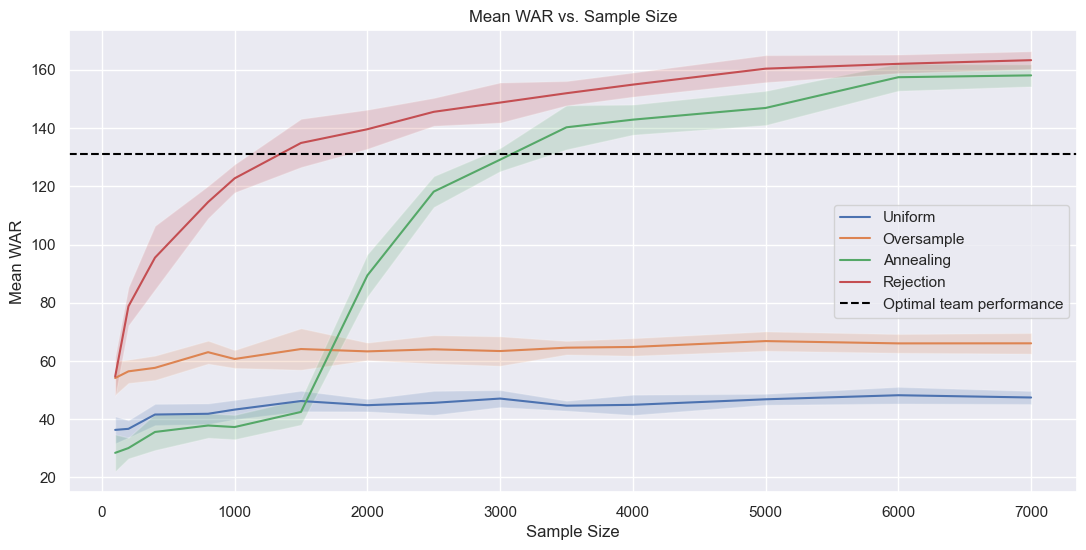

In [ ]:
# Plot the means as lines and standard deviations as shaded regions 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()

fig, ax = plt.subplots(figsize=(13, 6))
for key in means:
    ax.plot(sizes, means[key], label=key)
    ax.fill_between(sizes, np.array(means[key]) - np.array(sd[key]), np.array(means[key]) + np.array(sd[key]), alpha=0.2)
# plot the ground truth
ax.axhline(y=ground_truth, color="black", linestyle="--", label="Optimal team performance")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Mean WAR")
ax.set_title("Mean WAR vs. Sample Size")
ax.legend()


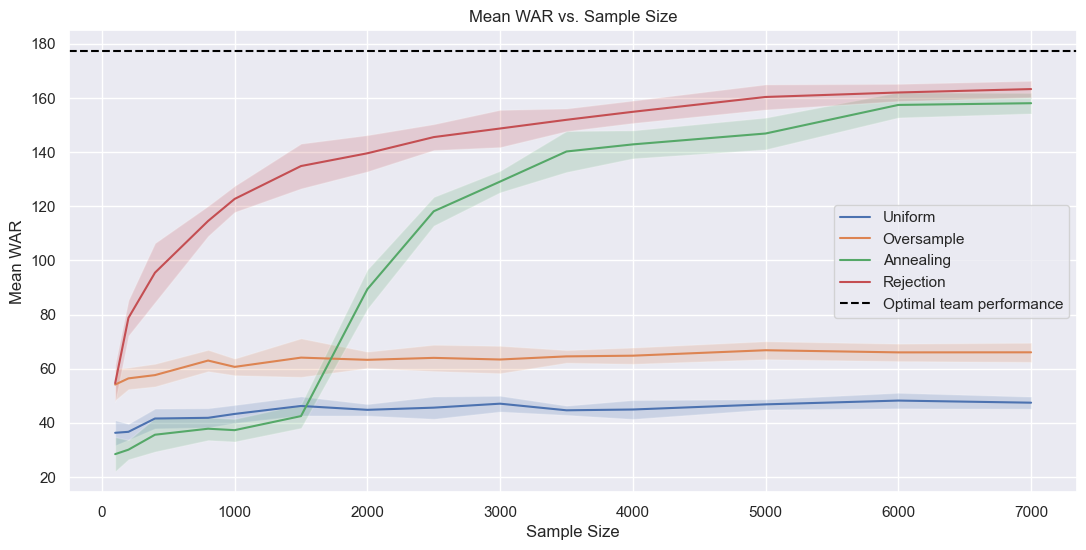

In [ ]:
# Plot the means as lines and standard deviations as shaded regions 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()

fig, ax = plt.subplots(figsize=(13, 6))
for key in means:
    ax.plot(sizes, means[key], label=key)
    ax.fill_between(sizes, np.array(means[key]) - np.array(sd[key]), np.array(means[key]) + np.array(sd[key]), alpha=0.2)
# plot the ground truth
ax.axhline(y=ground_truth, color="black", linestyle="--", label="Optimal team performance")
ax.set_xlabel("Sample Size")
ax.set_ylabel("Mean WAR")
ax.set_title("Mean WAR vs. Sample Size")
ax.legend()

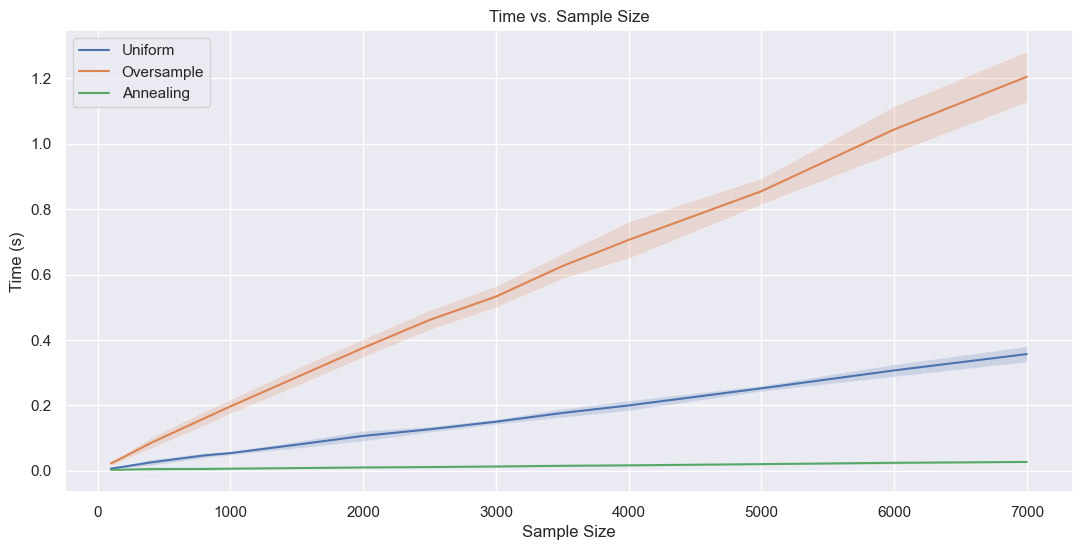

In [ ]:
# Do the same for the times
fig, ax = plt.subplots(figsize=(13, 6))
for key in times:
    ax.plot(sizes, times[key], label=key)
    ax.fill_between(sizes, np.array(times[key]) - np.array(sd_time[key]), np.array(times[key]) + np.array(sd_time[key]), alpha=0.2)
ax.set_xlabel("Sample Size")
ax.set_ylabel("Time (s)")
ax.set_title("Time vs. Sample Size")
ax.legend()

TypeError: unhashable type: 'slice'

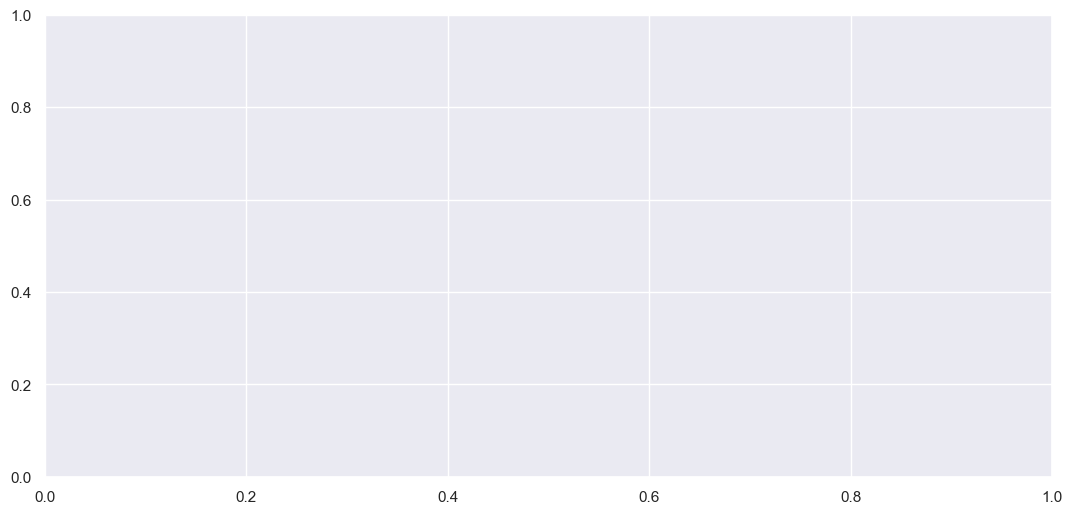

In [ ]:
ground_truth = ground_truth

# Plot the samples as histograms 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] = 'STIXGeneral'
sns.set()

fig, ax = plt.subplots(figsize=(13, 6))
for key in samples[:12800]:
    sns.distplot(samples[key], label=key, bins=20)
# Plot ground truth as a vertical line
ax.axvline(ground_truth, color="black", linestyle="--", label = "LP solution - Optimum")
# legend with legend position
ax.legend()
# Add title
ax.set_title("Sampling distributions", size = 15)
# Add x-axis label
ax.set_xlabel("WAR")
# Add y-axis label
ax.set_ylabel("Density")
plt.show()

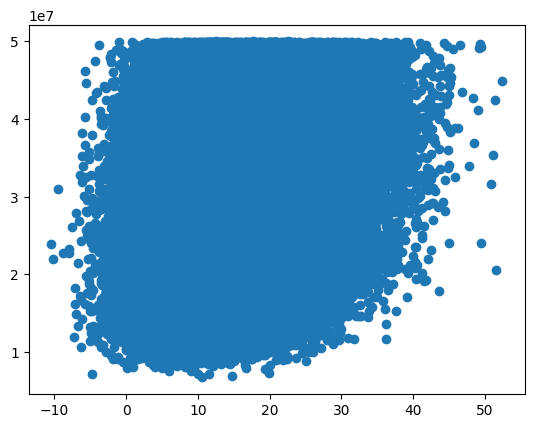

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x=[]
y=[]

# Generate some sample data
for i in range(100000):
    sample = df1.sample(n=26, replace=False)
    if sum(sample["salary"]) <= BUDGET:
        sum(sample["br_WAR_total"])
        y.append(sum(sample["salary"]))
        x.append(sum(sample["br_WAR_total"]))

# plot x against y
plt.scatter(x, y)

In [24]:
import itertools

numbers = [1, 2, 3, 7, 7, 9, 10, 1, 2, 3, 7, 7, 9, 10, 1, 2, 3, 7, 7, 9, 10, 1, 2, 3, 7, 7, 9, 10, 1, 2, 3, 7, 7, 9, 10, 1, 2, 3, 7, 7, 9, 10]
target = 10

result = [seq for i in range(len(numbers), 0, -1)
          for seq in itertools.combinations(numbers, i)
          if sum(seq) == target]

print(result)

KeyboardInterrupt: 

In [30]:
result = [seq for i in range(len(numbers), 0, -1)
          for seq in itertools.combinations(numbers, i)
          if sum(seq) <= target]

KeyboardInterrupt: 